In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.rl_data_record import RLDataRecord
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()
reward_model = RewardModel(config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    # print(
    #     f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    # )
    # print(
    #     f"batch ids: {[e.id for e in dataset.get_episods(batch_episode_indices=list(batch_repeat_sampler))]}"
    # )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

train_dataset : 1000000
test_dataset : 1000
eval_dataset : 100000
data loader: TRAIN, 1500
data loader: TEST, 75
data loader: EVAL, 75


In [3]:
# for idx, batch_data in enumerate(train_dataloader):
#     batch_episode_indices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_indices)}, batch ids: {[e.id for e in train_dataset.get_episods(batch_episode_indices=batch_episode_indices)]}"
#     )

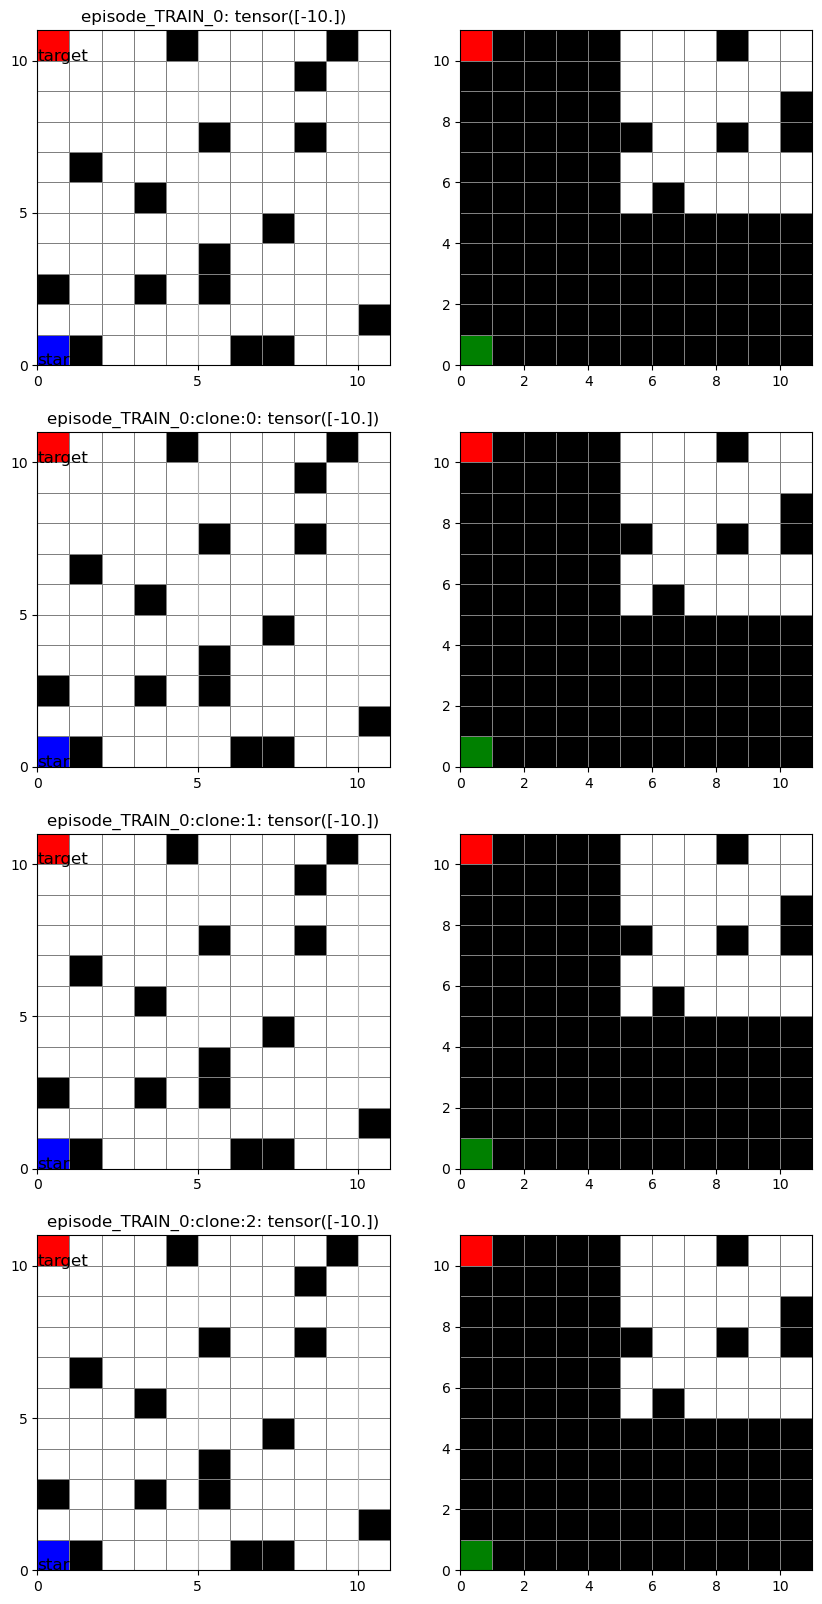

In [4]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

step: 0, logits: tensor([[ -69.4143,  319.7902, -208.5829,  -62.4245, -141.1978,  220.6715,
           56.4063,    8.0418,   67.1058]]), logit_prob: tensor([[0.1866]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([0., 0.]), action_history: []
step: 1, logits: tensor([[ -69.4143,  319.7902, -208.5829,  -62.4245, -141.1978,  220.6715,
           56.4063,    8.0418,   67.1058]]), logit_prob: tensor([[0.1866]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([0., 0.]), action_history: []
step: 2, logits: tensor([[ -69.4143,  319.7902, -208.5829,  -62.4245, -141.1978,  220.6715,
           56.4063,    8.0418,   67.1058]]), logit_prob: tensor([[0.1866]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([0., 0.]), action_history: []
step: 3, logits: tensor([[ -69.4143,  319.7902, -208.5829,  -62.4245, -141.1978,  220.6715,
           56.4063,    8.0418,   67.1058]]), logit_prob: tensor([[0.1866]]), top_k_prob: tensor([[1.]]),

/Users/chengbai/ml/cheng_git/rf_agent/src/policy.py:28: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  layer.weight = nn.init.kaiming_uniform(layer.weight)


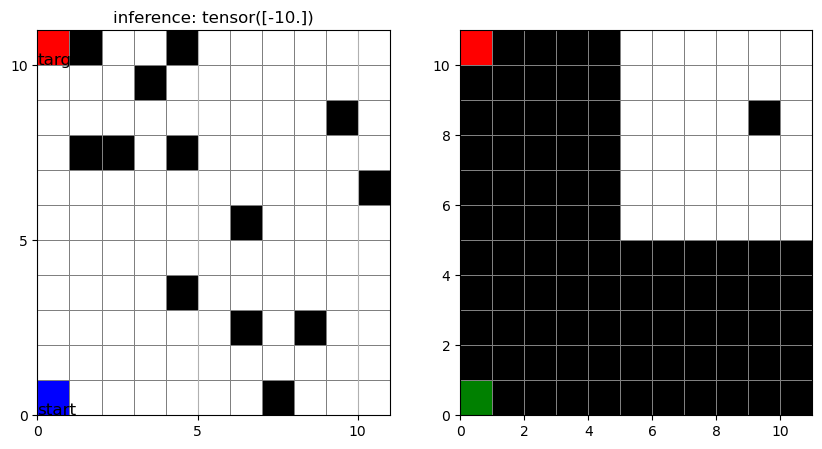

In [5]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(
    policy=test_policy, config=config, reward_model=reward_model, steps=5, debug=True
)
# episode.agent.action_history

In [6]:
# np.linalg.norm([8, 6], ord=1)
episode.reward(reward_model=reward_model)

tensor([-10.])

# Training Loop
---

In [7]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[ 292.5174,   77.1089, -121.5025,  -75.4900,  279.9355,   18.6647,
          113.1770,  554.1265,  -75.1408]]), logit_prob: tensor([[0.2013]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([0., 0.]), action_history: []
step: 1, logits: tensor([[ 292.5174,   77.1089, -121.5025,  -75.4900,  279.9355,   18.6647,
          113.1770,  554.1265,  -75.1408]]), logit_prob: tensor([[0.2013]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([0., 0.]), action_history: []
step: 2, logits: tensor([[ 292.5174,   77.1089, -121.5025,  -75.4900,  279.9355,   18.6647,
          113.1770,  554.1265,  -75.1408]]), logit_prob: tensor([[0.2013]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([0., 0.]), action_history: []
step: 3, logits: tensor([[ 292.5174,   77.1089, -121.5025,  -75.4900,  279.9355,   18.6647,
          113.1770,  554.1265,  -75.1408]]), logit_prob: tensor([[0.2013]]), top_k_prob: tensor([[1.]]),

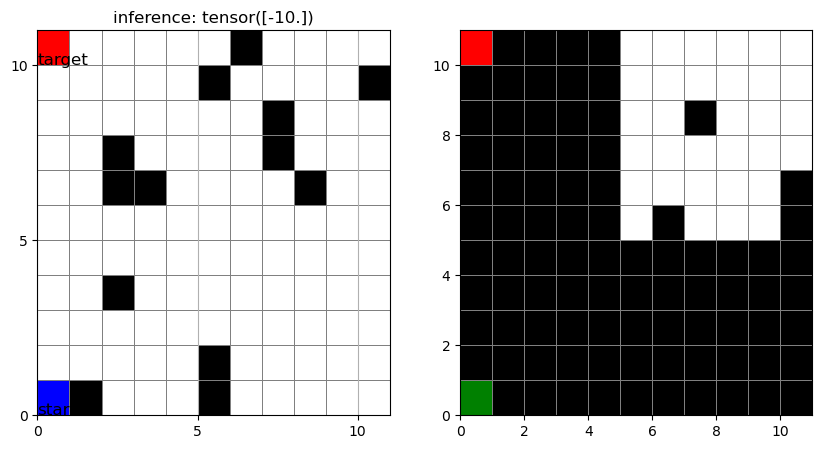

In [8]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(
    policy=policy, config=config, reward_model=reward_model, steps=5, debug=True
)

In [9]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

train_dataloader: 1500, eval_dataloader: 75


Epoch 1:   2%|▏         | 29/1500 [00:17<14:36,  1.68it/s, split=TRAIN, step=1, batch_idx=28, is_episode_step_done=0]


ValueError: The histogram is empty, please file a bug report.

In [ ]:
# post model training
episode = inference_and_plot_policy(
    policy=policy,
    config=config,
    reward_model=reward_model,
    steps=15,  # config.episode_steps,
    debug=True,
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

In [ ]:
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

# Evaluate the Model
----

In [ ]:
# policy_model_path = (
#     "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
# )
# trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
# assert trained_policy is not None

# episode = inference_and_plot_policy(
#     policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
# )